Сгенерируем множество точек-кандидатов и начальный дизайн.

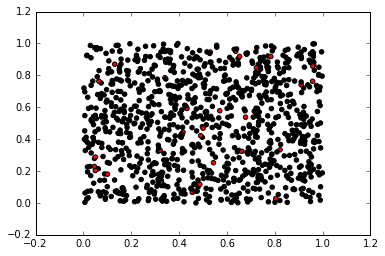

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

ALL_POINTS = 1000
TEST_SIZE = 100
INITIAL_POINTS = 30

all_points = np.random.random((ALL_POINTS+TEST_SIZE, 2))
test = all_points[-TEST_SIZE:, :]
all_points = np.delete(all_points, range(ALL_POINTS, ALL_POINTS+TEST_SIZE), axis=0)

initial_sample_indices = np.random.randint(ALL_POINTS, size=INITIAL_POINTS)
initial_sample = all_points[initial_sample_indices, :]
colors = ['red' if num in initial_sample_indices else 'black' for num in range(ALL_POINTS) ]

plt.scatter(all_points[:, 0], all_points[:, 1], c=colors)

all_points = np.delete(all_points, initial_sample_indices, axis=0)

В качестве целевой функции выберем $f(x, y)=\frac{1}{x^2 + y^2}$

In [3]:
def func(point):
    return 1/(point[0] ** 2 + point[1] ** 2)

Функция, реализующая первый и второй критерии, требуемые в задании:

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

def criterion(points, cur_sample, mode):
    if mode == 'random':
        index = np.random.randint(points.shape[0]) 
        return points[index], index
    
    elif mode == 'distance':
        
        max_min_distance, choosen_point = 0, 0
        for index, point in zip(range(points.shape[0]), points):
            
            min_distance = 100
            for sample_point in cur_sample:
                
                dist = (point[0] - sample_point[0]) ** 2 + (point[1] - sample_point[1]) ** 2
                if dist < min_distance:
                    min_distance = dist
            
            if min_distance > max_min_distance:
                max_min_distance = min_distance
                choosen_point, res_index = point, index
                
        return choosen_point, res_index
    

Функция для построения модели:

In [5]:
import copy
def perform_fit(mode, num_points):
    cur_sample = copy.copy(initial_sample)
    points = copy.copy(all_points)
    
    cur_sample_values = [func(p) for p in cur_sample]
    test_values = [func(p) for p in test]

    gpr = GPR()
    gpr.fit(cur_sample, cur_sample_values)
    ans = gpr.predict(test)

    errors = [np.sum((test_values - ans) ** 2)/len(test_values)]

    for i in range(num_points):
        point, index = criterion(points, cur_sample, mode=mode)
        points = np.delete(points, index, axis=0)
        cur_sample = np.append(cur_sample, [point], axis=0)
        cur_sample_values.append(func(point))
        
        gpr.fit(cur_sample, cur_sample_values)
        ans = gpr.predict(test)

        errors.append(np.sum((test_values - ans) ** 2)/len(test_values))

    plt.plot(range(num_points+1), errors)
    

Случайный выбор точки:

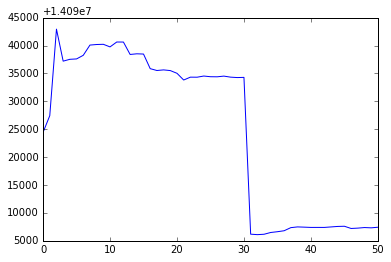

In [6]:
perform_fit('random', 50)

Выбор точки с максимальным минимальным расстоянием до текущей выборки:

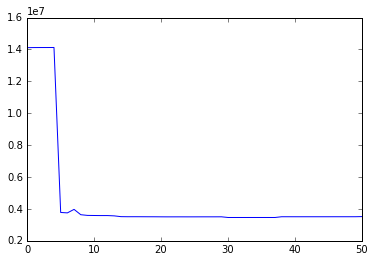

In [7]:
perform_fit('distance', 50)

Выбор точки с максимальной апостериорной дисперсией.

In [8]:
from numpy.linalg import inv
NUM_POINTS = 1

cur_sample = copy.copy(initial_sample)
points = copy.copy(all_points)

cur_sample_values = [func(p) for p in cur_sample]
test_values = [func(p) for p in test]

gpr = GPR(n_restarts_optimizer=5)
gpr.fit(cur_sample, cur_sample_values)
ans = gpr.predict(test)

errors = [np.sum((test_values - ans) ** 2)/len(test_values)]

for i in range(NUM_POINTS):
    min_var = 1e11
    res_point, res_index = 0, 0
    
    for index, point in zip(range(points.shape[0]), points):
        tmp_sample = np.append([point], cur_sample, axis=0)
        K = gpr.kernel_(cur_sample)
        k = gpr.kernel_(tmp_sample)[0, 1:]
        kxx = gpr.kernel_([point])[0, 0]
        
        var = kxx - np.dot(np.dot([k], inv(K)), np.transpose([k]))[0, 0]/np.dot([k], np.transpose([k]))[0, 0]
        print np.dot([k], inv(K)).shape, np.transpose([k]).shape
        print var
        break
            
#     errors.append(min_error)
#     points = np.delete(points, res_index, axis=0)
#     cur_sample = np.append(cur_sample, [res_point], axis=0)
#     cur_sample_values.append(func(res_point))
    
plt.plot(range(NUM_POINTS+1), errors)

LinAlgError: Singular matrix

In [ ]:
NUM_POINTS = 50

cur_sample = copy.copy(initial_sample)
points = copy.copy(all_points)

cur_sample_values = [func(p) for p in cur_sample]
test_values = [func(p) for p in test]

gpr = GPR()
gpr.fit(cur_sample, cur_sample_values)
ans = gpr.predict(test)

errors = [np.sum((test_values - ans) ** 2)/len(test_values)]

for i in range(NUM_POINTS):
    min_error = 1e11
    res_point, res_index = 0, 0
    
    for index, point in zip(range(points.shape[0]), points):
        tmp_sample = np.append(cur_sample, [point], axis=0)
        tmp_values = np.append(cur_sample_values, func(point))
        gpr.fit(tmp_sample, tmp_values)
        
        ans = gpr.predict(test)
        error = np.sum((test_values - ans) ** 2)/len(test_values)
        
        if error < min_error:
            min_error = error
            res_point, res_index = point, index
            
    errors.append(min_error)
    points = np.delete(points, res_index, axis=0)
    cur_sample = np.append(cur_sample, [res_point], axis=0)
    cur_sample_values.append(func(res_point))
    
plt.plot(range(NUM_POINTS+1), errors)

In [ ]:
gpr.kernel_(np.array([[1, 2], [2, 3]]))

In [ ]:
np.transpose(np.array([1, 2]))

In [2]:
1 / float(3)

0.3333333333333333